In [29]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA data mixing ablation")
Altruistic_Flores = spreadsheet.worksheet("Altruistic-Flores-200-X-Eng-BLEU")

In [5]:
Altruistic_Flores_Data = Altruistic_Flores.get_all_records(value_render_option="UNFORMATTED_VALUE")
df_Altruistic_Flores = pd.DataFrame(Altruistic_Flores_Data, columns=Altruistic_Flores_Data[0])

In [6]:
languages = ['zho_Hans-eng_Latn', 'ceb_Latn-eng_Latn', 'mar_Deva-eng_Latn', 'zul_Latn-eng_Latn', 'khm_Khmr-eng_Latn']
df_selected = df_Altruistic_Flores[['Model'] + languages]

In [7]:
df_long = df_selected.melt(id_vars='Model', var_name='Language', value_name='Score')

resource_map = {
    'zho_Hans-eng_Latn': 'High',
    'ceb_Latn-eng_Latn': 'Mid',
    'mar_Deva-eng_Latn': 'Mid',
    'zul_Latn-eng_Latn': 'Low',
    'khm_Khmr-eng_Latn': 'Low'
}
df_long['Resource_Level'] = df_long['Language'].map(resource_map)

In [8]:
def extract_base(model_name):
    if 'Llama-2-7B' in model_name:
        return 'Llama-2-7B'
    elif 'Llama-3.1-8B' in model_name:
        return 'Llama-3.1-8B'
    elif 'Viking-7B' in model_name:
        return 'Viking-7B'
    else:
        return 'Other'
    
def extract_data_combination(model_name):
    if 'Bilingual-Code' in model_name:
        return 'Bilingual-Code'
    elif 'Bilingual' in model_name:
        return 'Bilingual'
    elif 'Monolingual-Code' in model_name:
        return 'Monolingual-Code'
    elif 'Monolingual' in model_name:
        return 'Monolingual'
    else:
        return 'Unknown'

df_long['Base_Model'] = df_long['Model'].apply(extract_base)
df_long['Data_Combination'] = df_long['Model'].apply(extract_data_combination)

In [12]:
df_agg = df_long.groupby(['Base_Model','Data_Combination','Resource_Level'], as_index=False)['Score'].mean()

data_combination_order = ['Bilingual', 'Bilingual-Code', 'Monolingual', 'Monolingual-Code']
resource_order = ['High','Mid','Low']
# base_model_order = ['Llama-2-7B','Llama-3.1-8B','Viking-7B']
base_model_order = ['Llama-2-7B','Viking-7B']

df_agg['Data_Combination'] = pd.Categorical(df_agg['Data_Combination'], categories=data_combination_order, ordered=True)
df_agg['Resource_Level'] = pd.Categorical(df_agg['Resource_Level'], categories=resource_order, ordered=True)

In [13]:
df_agg

,Base_Model,Data_Combination,Resource_Level,Score
0,Llama-2-7B,Bilingual,High,18.350371
1,Llama-2-7B,Bilingual,Low,16.268745
2,Llama-2-7B,Bilingual,Mid,23.488472
3,Llama-2-7B,Bilingual-Code,High,13.031056
4,Llama-2-7B,Bilingual-Code,Low,4.950766
5,Llama-2-7B,Bilingual-Code,Mid,8.255188
6,Llama-2-7B,Monolingual,High,16.850501
7,Llama-2-7B,Monolingual,Low,15.522624
8,Llama-2-7B,Monolingual,Mid,22.991202
9,Llama-2-7B,Monolingual-Code,High,17.967803


/tmp/ipykernel_3353146/2387441553.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


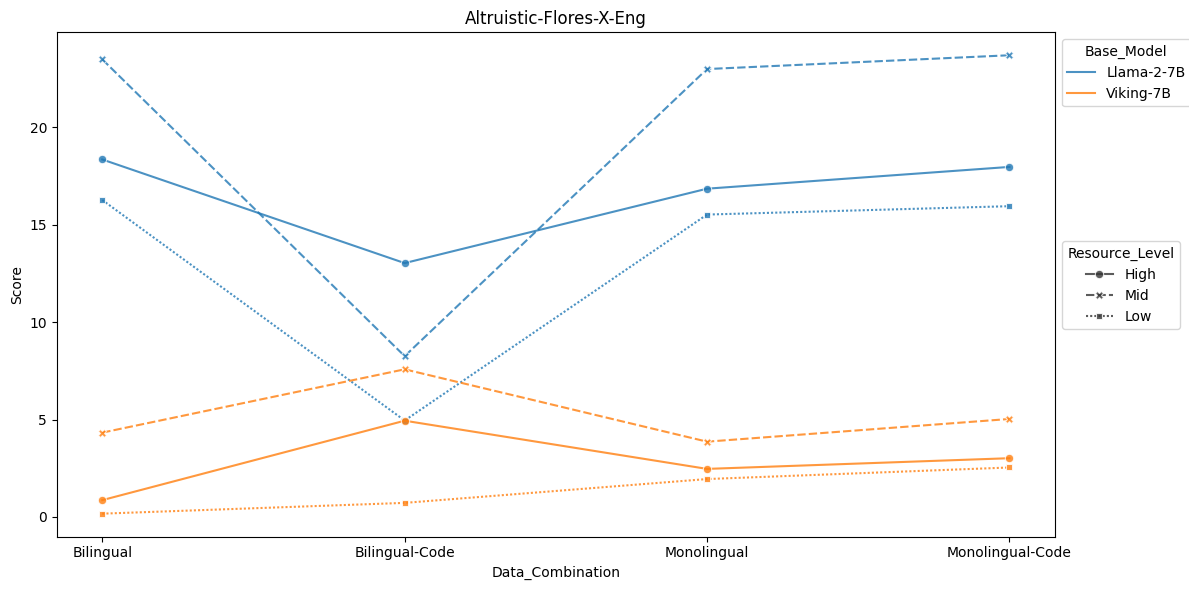

In [14]:
plt.figure(figsize=(12, 6))
lineplot = sns.lineplot(
    data=df_agg,
    x="Data_Combination",
    y="Score",
    hue="Base_Model",
    style="Resource_Level",
    markers=True,
    dashes=True,
    ci=None,
    hue_order=base_model_order,
    style_order=resource_order,
    linewidth=1.5,
    alpha=0.8,
)

plt.title("Altruistic-Flores-X-Eng")
plt.xticks(rotation=0)

handles, labels = lineplot.get_legend_handles_labels()

base_handles = []
base_labels = []
style_handles = []
style_labels = []

for handle, label in zip(handles, labels):
    if label in base_model_order:
        base_handles.append(handle)
        base_labels.append(label)
    elif label in resource_order:
        style_handles.append(handle)
        style_labels.append(label)

lineplot.legend_.remove()

plt.subplots_adjust(right=0.7)

legend_base = plt.legend(
    base_handles,
    base_labels,
    title="Base_Model",
    bbox_to_anchor=(1.0, 1),
    loc="upper left",
)
plt.gca().add_artist(legend_base)

plt.legend(
    style_handles,
    style_labels,
    title="Resource_Level",
    bbox_to_anchor=(1.0, 0.6),
    loc="upper left",
)

plt.tight_layout()
plt.show()

In [33]:
df = df_agg[df_agg['Base_Model'].isin(['Llama-2-7B', 'Viking-7B'])]

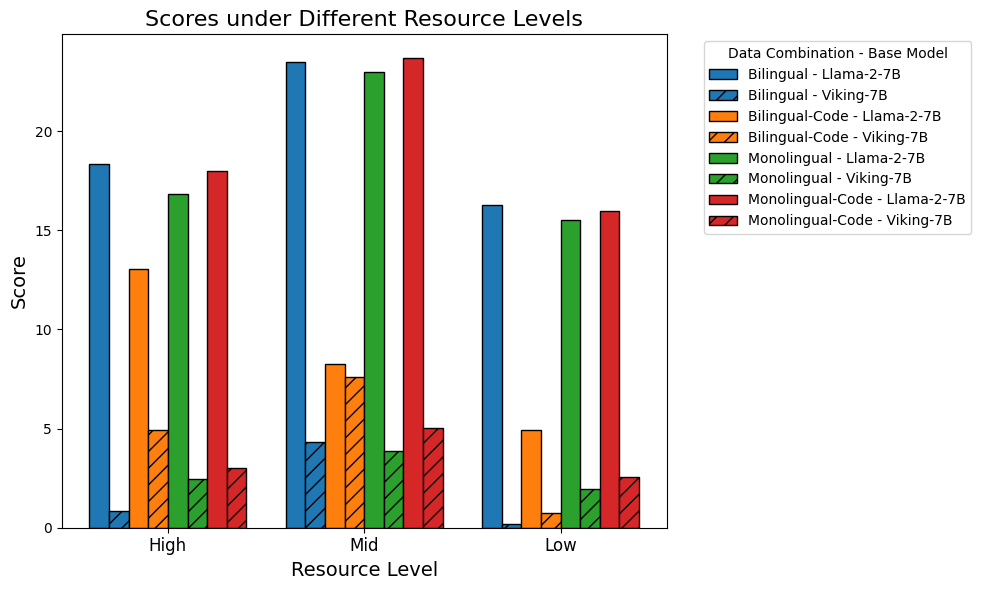

In [35]:


# ===== 2. 先定义我们需要在图中显示的顺序，和配色等 =====
resource_levels = ['High', 'Mid', 'Low']  # x轴上三大组
data_combinations = ['Bilingual', 'Bilingual-Code', 'Monolingual', 'Monolingual-Code']  # 4个数据组合
base_models = ['Llama-2-7B', 'Viking-7B']  # 2个Base Model

# 4种主要配色（你也可以换成 seaborn 自带调色板、或者其他你喜欢的颜色）
colors = {
    'Bilingual':        '#1f77b4',  # 蓝
    'Bilingual-Code':   '#ff7f0e',  # 橙
    'Monolingual':      '#2ca02c',  # 绿
    'Monolingual-Code': '#d62728',  # 红
}

# 为了区分同一种颜色下两个 Base_Model 的柱子，可以用 hatch（填充纹理）
# 也可以用不同深浅、不同透明度等方式，本示例采用 hatch 来区分
hatches = ['', '//']  # 第一个base model不加纹理，第二个加 '//' 纹理

# ===== 3. 开始画图 =====
fig, ax = plt.subplots(figsize=(10, 6))

# 每个 Resource_Level 对应 x 轴上的一个主刻度
x = np.arange(len(resource_levels))  # 即 [0,1,2] 分别对应 High, Mid, Low
bar_width = 0.1                     # 每根柱子的宽度
# 整个大组 (4个 Data_Combination × 2个 Base_Model = 8 根柱) 的总宽度 ~ 8 × bar_width = 0.8

# 遍历 4个数据组合 × 2个base model
for i, data_combo in enumerate(data_combinations):
    for j, base_model in enumerate(base_models):
        # 计算在这一组 x 的偏移量 offset
        # i 表示第几个 data combination，j 表示在这组合下的第几个 base model
        offset = (i * len(base_models) + j) * bar_width
        
        # 根据 Resource_Level 顺序，取到对应的 Score
        y_values = []
        for level in resource_levels:
            # 假设每个 (Resource_Level, Data_Combination, Base_Model) 唯一对应该条目
            score = df.loc[
                (df['Resource_Level'] == level) &
                (df['Data_Combination'] == data_combo) &
                (df['Base_Model'] == base_model),
                'Score'
            ].values[0]
            y_values.append(score)
        
        # 设置标签（legend），避免重复可直接用组合
        label = f"{data_combo} - {base_model}"
        
        # 绘制柱子
        ax.bar(
            x + offset,       # 横坐标(要加offset使得多柱并排)
            y_values, 
            width=bar_width,
            color=colors[data_combo],
            hatch=hatches[j],
            edgecolor='black',
            label=label
        )

# ===== 4. 美化 x 轴刻度等 =====
# 为了让 x 轴刻度居中在该组的中间，需要在 x 的基础上加一半的大组宽度(减去1个 bar_width)
group_total_width = len(data_combinations) * len(base_models) * bar_width  # ~ 8 × 0.1 = 0.8
ax.set_xticks(x + group_total_width/2 - bar_width/2)
ax.set_xticklabels(resource_levels, fontsize=12)
ax.set_xlabel('Resource Level', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

# 处理图例去重，因为上面循环会重复添加 label
handles, labels = ax.get_legend_handles_labels()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)
ax.legend(unique_handles, unique_labels, title='Data Combination - Base Model', 
          bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Scores under Different Resource Levels', fontsize=16)
plt.tight_layout()
plt.show()